# Can we use eGSIM to compare observations against physics-based simulations?

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

# Python standard library imports
import io
import os
import json
import requests
from typing import List, Dict, Tuple, Optional

# Numeric/scientific Python etc.
import numpy as np
import pandas as pd

# Visualization tools
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import seaborn as sns


# How to call eGSIM's API to get Ground Motion Model Residuals

In [3]:
# Set the eGSIM URL to get the ground motion residuals
egsim_url_residuals = "https://egsim.gfz-potsdam.de/api/query/residuals"


def get_residuals_from_egsim(
    flatfile_path: str,
    gmms: List,
    imts: List,
    data_format: str = "hdf",
    query_string: str = ""
) -> Dict:
    """Retreive the residuals for the flatfile and the selected
    set of ground motion models and intensity measure types

    Args:
        flatfile_path: Local path to the selected flatfile
        gmms: List of ground motion models (OpenQuake class names)
        imts: List of intensity measure types (e.g. PGA, PGV, SA(0.1) etc.)
        plot_type: Column to return for x-values (e.g. mag, rrup, etc)
        query_string: Selection query to apply to the data

    Returns:
        json_response: Response of the POST request in json form (if successful)
                       or the response class (if unsuccessful)
    """
    assert data_format in ("hdf", "csv"), "Data format must be either 'hdf' or 'csv'"
    # Retreive residuals for a given plot type
    parameters = {
            "model": gmms,
            "imt": imts,
            "format": data_format      
    }
    # Add the query string, if supplied
    if query_string:
        parameters["data-query"] = query_string

    with open(flatfile_path, "rb") as flatfile:
        files = {"flatfile": flatfile}
        try:
            # POST request for eGSIM
            response = requests.post(
                egsim_url_residuals,
                files=files,
                data=parameters
            )
            response.raise_for_status()
        except requests.exceptions.HTTPError as exc:
            # Get more detailed message as to why the call failed
            code = exc.response.status_code
            msg = response.json()['message']
            print(f"HTTPError (code={code}): {msg}")
        except:
            # Just fail
            print(exc.response.status_code)
            print("Response failed - see status message")
            raise  
    
    if parameters['format'] == 'hdf':
        # `pd.read_hdf` works for HDF files on disk. Workaround:
        with pd.HDFStore(
                "data.h5",  # apparently unused for in-memory data
                mode="r",
                driver="H5FD_CORE",  # create in-memory file
                driver_core_backing_store=0,  # for safety, just in case
                driver_core_image=response.content) as store:
            dframe = store[list(store.keys())[0]]
    else:
        # use `pd.read_csv` with a BytesIO (file-like object) as input: 
        dframe = pd.read_csv(io.BytesIO(response.content), header=[0, 1, 2], index_col=0)        

    return dframe

## <u><i>If you can create the flatfile, you can use eGSIM!</i></u> 

# Workflow

### Observed Ground Motions from the Kahramanmara&#351; Earthquake

Ground motion data taken from ESM (<https://esm-db.eu/#/home> - Accessed 23/06/2023), selecting all records **not** flagged as poor quality.

Only events with 3 or more good quality records are selected

**Ground motion PGA, PGV and SA(T) are given in terms of RotD50**


In [4]:
# Load in and view the flatfile
observation_flatfile = "./data/flatfiles/Turkiye2023_ESM_RotD50_flatfile.csv"
observations = pd.read_csv(observation_flatfile, sep=',')

# Limit to just the first mainshock
observations = observations[observations["event_id"] == "INT-20230206_0000008"]
observations

,gmid,event_id,event_time,event_longitude,event_latitude,event_depth,magnitude,strike,dip,rake,...,SA(5.500),SA(6.000),SA(6.500),SA(7.000),SA(7.500),SA(8.000),SA(8.500),SA(9.000),SA(9.500),SA(10.000)
0,INT-20230206_0000008|KO-TUNC|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.016487,0.014861,0.014393,0.011889,0.012162,0.012471,0.014036,0.014549,0.014635,0.014623
1,INT-20230206_0000008|TK-0118|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.036545,0.029734,0.031675,0.029825,0.027148,0.024118,0.022191,0.019858,0.019691,0.019082
2,INT-20230206_0000008|TK-0119|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.020589,0.020201,0.024237,0.023534,0.020944,0.020848,0.022582,0.023533,0.023470,0.022722
3,INT-20230206_0000008|TK-0122|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.013690,0.016388,0.015815,0.013882,0.011818,0.010670,0.010296,0.010078,0.009312,0.008557
4,INT-20230206_0000008|TK-0123|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.042793,0.033323,0.036449,0.031333,0.027435,0.027360,0.027831,0.025207,0.024198,0.022768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,INT-20230206_0000008|TK-5809|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.018699,0.015004,0.013941,0.014296,0.013688,0.011437,0.010705,0.010767,0.010731,0.009871
239,INT-20230206_0000008|TK-5810|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.015638,0.012937,0.014413,0.016966,0.019044,0.019509,0.018363,0.016176,0.014067,0.012269
240,INT-20230206_0000008|TK-5811|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.012775,0.010749,0.008898,0.007984,0.008121,0.008615,0.009225,0.009856,0.009793,0.008786
241,INT-20230206_0000008|TK-5812|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.014359,0.017533,0.019971,0.023052,0.024384,0.023649,0.022175,0.020171,0.017944,0.015445


### Simulations of the Earthquake made from the SeisSol Software

We have been kindly provided with results of a simulation for the Kahramanmaras first shock (Mw 7.8) that was undertaken using the software SeisSol

*The simulations were created by Thomas Ulrich, Alice Gabriel and colleagues from LMU Munich for which we appreciate this data being shared*

We have processed velocity time-series and using the USGS rupture model calculated the required source, path and site metadata. PGV, PGA and Sa(T) were retreived in terms of RotD50

In [5]:
seissol_flatfile = "./data/flatfiles/Kahramanmaras_1st_EQ_SeisSol_Allsites.csv"
simulations = pd.read_csv(seissol_flatfile, sep=',')
simulations

,gmid,event_id,event_time,event_longitude,event_latitude,event_depth,magnitude,strike,dip,rake,...,SA(5.500),SA(6.000),SA(6.500),SA(7.000),SA(7.500),SA(8.000),SA(8.500),SA(9.000),SA(9.500),SA(10.000)
0,INT-20230206_0000008|UNK-00001-12023,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.042,37.166,17.9,7.83,41.563938,80.96893,-1.0,...,0.053704,0.043235,0.036471,0.030689,0.026119,0.023677,0.020920,0.019002,0.017527,0.016051
1,INT-20230206_0000008|UNK-00002-00871,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.042,37.166,17.9,7.83,41.563938,80.96893,-1.0,...,0.005400,0.006193,0.005034,0.004315,0.003700,0.003799,0.004104,0.004342,0.004548,0.004681
2,INT-20230206_0000008|UNK-00003-06775,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.042,37.166,17.9,7.83,41.563938,80.96893,-1.0,...,0.008516,0.007892,0.007317,0.006176,0.005362,0.005853,0.006165,0.006146,0.006355,0.006533
3,INT-20230206_0000008|UNK-00004-06708,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.042,37.166,17.9,7.83,41.563938,80.96893,-1.0,...,0.016952,0.013817,0.011606,0.010232,0.009076,0.007751,0.006962,0.007362,0.007404,0.007097
4,INT-20230206_0000008|UNK-00005-14976,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.042,37.166,17.9,7.83,41.563938,80.96893,-1.0,...,0.037592,0.039340,0.044235,0.046267,0.043394,0.041756,0.039646,0.036415,0.032363,0.029927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,INT-20230206_0000008|TK-8003,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.042,37.166,17.9,7.83,41.563938,80.96893,-1.0,...,0.055136,0.051873,0.046580,0.041768,0.036156,0.033610,0.031380,0.029046,0.026687,0.024963
472,INT-20230206_0000008|TK-2309,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.042,37.166,17.9,7.83,41.563938,80.96893,-1.0,...,0.023801,0.023277,0.024372,0.024484,0.023436,0.022771,0.021422,0.019633,0.017842,0.016483
473,INT-20230206_0000008|TK-2308,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.042,37.166,17.9,7.83,41.563938,80.96893,-1.0,...,0.064723,0.071317,0.069331,0.065465,0.059427,0.052654,0.048554,0.045809,0.042571,0.038962
474,INT-20230206_0000008|TK-8004,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.042,37.166,17.9,7.83,41.563938,80.96893,-1.0,...,0.032379,0.031856,0.028651,0.023902,0.019962,0.017447,0.015595,0.013723,0.012173,0.011786


##### Compare the overall distribution of ground motion values

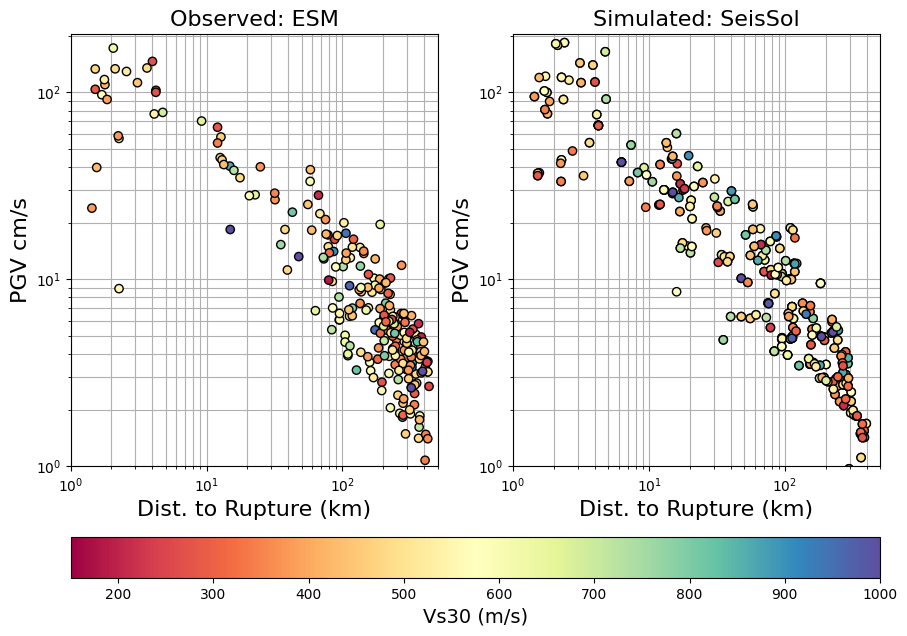

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(9, 7), layout="constrained")
# Plot the observations
axs[0].scatter(observations["rrup"], observations["PGV"],
               c=observations["vs30"], cmap="Spectral", edgecolor="k",
               norm=Normalize(150.0, 1000.0), zorder=4)
# Plot the simulations
cax = axs[1].scatter(simulations["rrup"], simulations["PGV"],
                     c=simulations["vs30"], cmap="Spectral", edgecolor="k",
                     norm=Normalize(150.0, 1000.0), zorder=4)
# Cleanup and annotate axes
axs[0].set_title("Observed: ESM", fontsize=16)
axs[1].set_title("Simulated: SeisSol", fontsize=16)
for ax in axs:
    ax.grid(which="both")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Dist. to Rupture (km)", fontsize=16)
    ax.set_ylabel("PGV cm/s", fontsize=16)
    ax.set_xlim(1, 500.0)
    ax.set_ylim(1, 205.0)
fig.tight_layout()
# Add colorbar
cbar = fig.colorbar(cax, ax=axs, location="bottom", pad=0.12)
_ = cbar.ax.set_xlabel("Vs30 (m/s)", fontsize=14)

# How do the between-event residuals ($\delta B_e$) compare for the Observations and Simulations of the $M_w$ 7.8 mainshock?

### Use the eGSIM API to get the mixed-effects residuals for some GMMs

Consider a larger set of periods between 0.02 s and 4.0 s (plus PGV and PGA)

In [7]:
periods = np.logspace(np.log10(0.02), np.log10(4.0), 20)
broadband_imts = ["PGV", "PGA"] + [f"SA({per})" for per in periods]
broadband_imts

['PGV',
 'PGA',
 'SA(0.020000000000000004)',
 'SA(0.026432414588672085)',
 'SA(0.03493362704937226)',
 'SA(0.04616900566275285)',
 'SA(0.061017914941231655)',
 'SA(0.0806425412531482)',
 'SA(0.10657885419436522)',
 'SA(0.14085682302255476)',
 'SA(0.18615929718876892)',
 'SA(0.24603198614146787)',
 'SA(0.32516097298828534)',
 'SA(0.4297394823041181)',
 'SA(0.567952608069188)',
 'SA(0.7506179401601185)',
 'SA(0.9920322296003653)',
 'SA(1.31109035890608)',
 'SA(1.7327641964908194)',
 'SA(2.290057081302631)',
 'SA(3.026586910235772)',
 'SA(4.0)']

**Select four ground motion models:**

1) **AkkarEtAlRjb2014**: European & Middle East (RESORCE)
 
2) **CauzziEtAl2014**: Global (Japan)

3) **ChiouYoungs2014**: Global (NGA West 2)

4) **KothaEtAl2020ESHM20**: Backbone GMM from ESHM20

In [8]:
# Select a few GMMs to compare
gmms = [
    "AkkarEtAlRjb2014", 
    "CauzziEtAl2014",  
    "ChiouYoungs2014",  
    "KothaEtAl2020ESHM20" 
]

residuals_observations_broadband = get_residuals_from_egsim(
    "./data/flatfiles/Turkiye2023_ESM_RotD50_flatfile.csv",
    gmms=gmms,
    imts=broadband_imts,
    query_string="(event_id == 'INT-20230206_0000008')"
)

residuals_simulations_broadband = get_residuals_from_egsim(
    "./data/flatfiles/Kahramanmaras_1st_EQ_SeisSol_Allsites.csv",
    gmms=gmms,
    imts=broadband_imts,
)

In [9]:
residuals_observations_broadband

PGA                                                     \
      total_residual                                                      
    AkkarEtAlRjb2014 CauzziEtAl2014 ChiouYoungs2014 KothaEtAl2020ESHM20   
0          -0.852342      -1.157988       -1.357503           -0.391066   
1           0.079026      -0.379244       -0.501050            0.329634   
2          -0.502696      -0.822359       -1.397302           -0.359700   
3          -0.080237      -0.440649       -0.842411            0.059887   
4          -0.308091      -0.661184       -1.113123           -0.144230   
..               ...            ...             ...                 ...   
238        -0.375675      -0.715914       -1.011952           -0.096321   
239        -0.886732      -1.214577       -1.676205           -0.715695   
240        -0.863380      -1.143410       -1.350543           -0.276197   
241        -1.237718      -1.499080       -1.777028           -0.669136   
242        -1.960999      -2.236168       -2.615955           -1.478564   

                                                                             \
    inter_event_residual                                                      
        AkkarEtAlRjb2014 CauzziEtAl2014 ChiouYoungs2014 KothaEtAl2020ESHM20   
0              -1.546868      -1.586017       -1.916988           -0.097330   
1              -1.546868      -1.586017       -1.899163           -0.097711   
2              -1.546868      -1.586017       -1.941173           -0.097711   
3              -1.546868      -1.586017       -1.934952           -0.097711   
4              -1.546868      -1.586017       -1.926467           -0.097711   
..                   ...            ...             ...                 ...   
238            -1.546868      -1.586017       -1.932715           -0.097330   
239            -1.546868      -1.586017       -1.908163           -0.097330   
240            -1.546868      -1.586017       -1.955665           -0.097330   
241            -1.546868      -1.586017       -1.923376           -0.097711   
242            -1.546868      -1.586017       -1.899815           -0.097711   

                                         ...            input_data             \
    intra_event_residual                 ...     rupture_parameter              
        AkkarEtAlRjb2014 CauzziEtAl2014  ...              event_id hypo_depth   
0              -0.105465      -0.184205  ...  INT-20230206_0000008       20.0   
1               0.964091       0.830366  ...  INT-20230206_0000008       20.0   
2               0.296059       0.253062  ...  INT-20230206_0000008       20.0   
3               0.781199       0.750365  ...  INT-20230206_0000008       20.0   
4               0.519537       0.463045  ...  INT-20230206_0000008       20.0   
..                   ...            ...  ...                   ...        ...   
238             0.441926       0.391742  ...  INT-20230206_0000008       20.0   
239            -0.144958      -0.257930  ...  INT-20230206_0000008       20.0   
240            -0.118141      -0.165212  ...  INT-20230206_0000008       20.0   
241            -0.548020      -0.628589  ...  INT-20230206_0000008       20.0   
242            -1.378615      -1.588889  ...  INT-20230206_0000008       20.0   

                                                                             \
                         site_parameter                                       
      mag rake      ztor         region station_id        vs30 vs30measured   
0    7.83 -1.0  1.608801              4    KO-TUNC  473.299622        False   
1    7.83 -1.0  1.608801              4    TK-0118  946.000000         True   
2    7.83 -1.0  1.608801              2    TK-0119  485.000000         True   
3    7.83 -1.0  1.608801              4    TK-0122  501.000000         True   
4    7.83 -1.0  1.608801              4    TK-0123  519.000000         True   
..    ...  ...       ...            ...        ...         ...          ...   
238  7.83 -1.

In [10]:
residuals_simulations_broadband

PGA                                                     \
      total_residual                                                      
    AkkarEtAlRjb2014 CauzziEtAl2014 ChiouYoungs2014 KothaEtAl2020ESHM20   
0          -2.228132      -2.025032       -3.150429           -1.926212   
1          -3.218862      -3.353356       -4.367383           -2.822558   
2          -2.931252      -3.110065       -4.310785           -2.915861   
3          -1.841228      -2.089835       -2.952080           -1.741541   
4          -0.951644      -1.253917       -1.826697           -0.888361   
..               ...            ...             ...                 ...   
471        -1.867308      -2.024068       -3.226588           -1.982533   
472        -2.030780      -2.254972       -3.222428           -2.103105   
473        -1.669578      -1.853771       -2.887829           -1.717499   
474        -1.667346      -1.869473       -2.933777           -1.766370   
475        -2.005493      -1.956260       -3.146376           -1.815202   

                                                                             \
    inter_event_residual                                                      
        AkkarEtAlRjb2014 CauzziEtAl2014 ChiouYoungs2014 KothaEtAl2020ESHM20   
0              -4.588228      -3.677999       -7.051809           -3.536344   
1              -4.588228      -3.677999       -6.583670           -3.536344   
2              -4.588228      -3.677999       -6.564610           -3.536344   
3              -4.588228      -3.677999       -6.593302           -3.536344   
4              -4.588228      -3.677999       -6.579879           -3.536344   
..                   ...            ...             ...                 ...   
471            -4.588228      -3.677999       -7.175789           -3.543298   
472            -4.588228      -3.677999       -6.566083           -3.543298   
473            -4.588228      -3.677999       -6.782696           -3.543298   
474            -4.588228      -3.677999       -6.823133           -3.543298   
475            -4.588228      -3.677999       -6.983657           -3.543298   

                                         ...            input_data             \
    intra_event_residual                 ...     rupture_parameter              
        AkkarEtAlRjb2014 CauzziEtAl2014  ...              event_id hypo_depth   
0               0.031727       0.433163  ...  INT-20230206_0000008       17.9   
1              -1.106000      -1.297416  ...  INT-20230206_0000008       17.9   
2              -0.775717      -0.980449  ...  INT-20230206_0000008       17.9   
3               0.476036       0.348736  ...  INT-20230206_0000008       17.9   
4               1.497610       1.437794  ...  INT-20230206_0000008       17.9   
..                   ...            ...  ...                   ...        ...   
471             0.446087       0.434420  ...  INT-20230206_0000008       17.9   
472             0.258360       0.133591  ...  INT-20230206_0000008       17.9   
473             0.673155       0.656287  ...  INT-20230206_0000008       17.9   
474             0.675718       0.635831  ...  INT-20230206_0000008       17.9   
475             0.287399       0.522761  ...  INT-20230206_0000008       17.9   

                                                                     \
                         site_parameter                               
      mag rake      ztor         region       station_id       vs30   
0    7.83 -1.0  1.608801              2  UNK-00001-12023  402.90045   
1    7.83 -1.0  1.608801              4  UNK-00002-00871  603.14410   
2    7.83 -1.0  1.608801              4  UNK-00003-06775  815.33105   
3    7.83 -1.0  1.608801              4  UNK-00004-06708  629.68024   
4    7.83 -1.0  1.608801              2  UNK-00005-14976  712.42334   
..    ...  ...       ...            ...              ...        ...   
471  7.83 -1.0  1.608801              2          TK-8003  350.00000   
472  7.83 -1.0

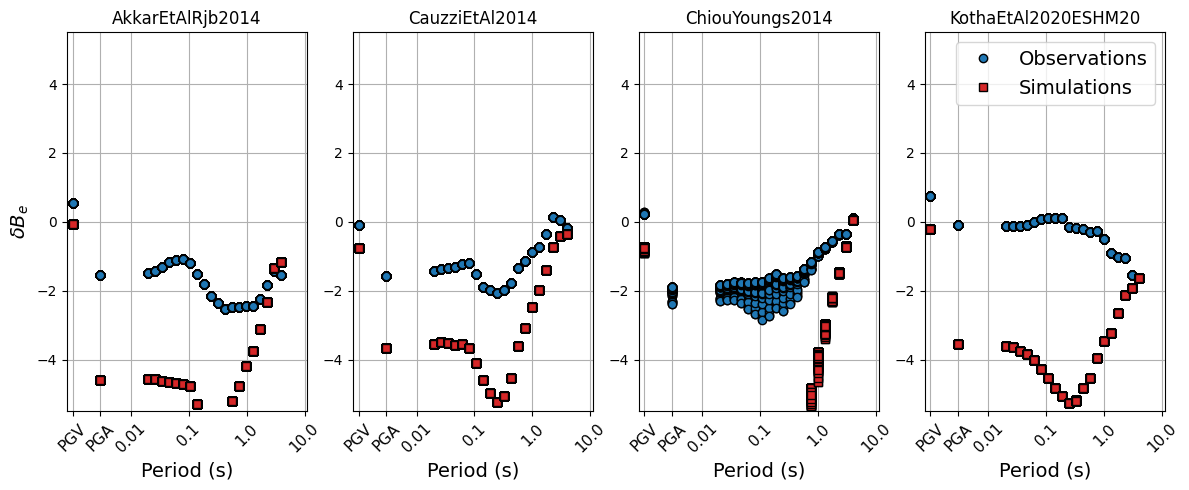

In [11]:
fig, axs = plt.subplots(1, len(gmms), figsize=(12,5))
lines = []
for i, gmm in enumerate(gmms):
    for j, imt in enumerate(broadband_imts):
        # Get dBe for the period (IMT)
        yvalues_obs = residuals_observations_broadband[imt]["inter_event_residual"][gmm]
        yvalues_sim = residuals_simulations_broadband[imt]["inter_event_residual"][gmm]
        # Set the x-label position corresponding to the IMT
        if imt == "PGV":
            period = 0.001
        elif imt == "PGA":
            period = 0.003
        else:
            period = float(imt.replace("SA(", "").replace(")", ""))

        xvalues_obs = [period] * len(yvalues_obs)
        xvalues_sim = [period] * len(yvalues_sim)
        # Plot ESM between-event residuals    
        line1 = axs[i].plot(xvalues_obs, yvalues_obs,
                            "o", mfc="tab:blue", mec="k",
                            label="Observations")
        line2 = axs[i].plot(xvalues_sim, yvalues_sim,
                            "s", mfc="tab:red", mec="k",
                            label="Simulations")
        lines.extend(line1)
        lines.extend(line2)
        
    axs[i].set_title(gmm, fontsize=12)

# Clean and harmonise the axes and legend
axs[0].set_ylabel(""r"$\delta B_e$", fontsize=14)    
axs[-1].legend(handles=lines[-2:], loc="upper right", fontsize=14)
for ax in axs.flatten():
    ax.set_xscale("log")
    ax.set_xlim(8.0E-4, 11)
    ax.set_ylim(-5.5, 5.5)
    ax.set_xlabel("Period (s)", fontsize=14)
    ax.set_xticks([0.001, 0.003, 0.01, 0.1, 1.0, 10.0],
                  ["PGV", "PGA", "0.01", "0.1", "1.0", "10.0"],)
    ax.tick_params(labelsize=11, axis="x", rotation=45)
    ax.grid(which="both")
fig.tight_layout(w_pad=0.05)

# Do simulations capture the same attenuation trends in within-event residuals $\delta W_{es}$?

Use a more limited set of intensity measure types

In [12]:
# Select some IMTs
imts = ["PGV", "PGA", "SA(0.2)", "SA(2.0)"]

In [13]:
residuals_observations = get_residuals_from_egsim(
    "./data/flatfiles/Turkiye2023_ESM_RotD50_flatfile.csv",
    gmms=gmms,
    imts=imts,
    query_string="(event_id == 'INT-20230206_0000008')"
)

residuals_simulations = get_residuals_from_egsim(
    "./data/flatfiles/Kahramanmaras_1st_EQ_SeisSol_Allsites.csv",
    gmms=gmms,
    imts=imts,
)

Here we can use Seaborn for visualization to compare linear trends in the residuals. But we need to convert between the dataframe format from eGSIM to that needed for Seaborn

In [14]:
RESIDUAL_NAMES = {
    "total_residual": "dtot",
    "inter_event_residual": "dbe",
    "intra_event_residual": "dwes"
}

def residuals_to_seaborn(residuals, predictor, residual_type, gmm_mapping=None,
                         label=None):
    """Get a sub-set of the residuals formatted in a dataframe suitable
    for analysis with Seaborn

    Args:
        residuals: eGSIM residuals dataframe
        predictor: Tuple of predictor predictor variable category and predictor,
                   e.g. (rupture_parameter, mag), (distance_measure, rrup),
                        (site_parameter, vs30) etc.
        residual_type: Which residual type to retrieve, e.g. total_residual,
                       inter_event_residual, intra_event_residual
        gmm_mapping: (Optional) mapping between the OpenQuake GMM name and
                     another alias name
        label: (Optional) add a column with a uniform label

    Returns:
        Dataframe with the predictor variable, IMT, GMM and residual
    """
    imts = residuals["input_data"]["intensity_measure"].columns.to_list()
    gmms = residuals[imts[0]]["total_residual"].columns.to_list()
    
    outputs = []
    for gmm in gmms:
        for imt in imts:
            xvals = residuals["input_data"][predictor[0]][predictor[1]].copy()
            yvals = residuals[imt][residual_type][gmm].copy()
            gmm_name = gmm_mapping[gmm] if gmm_mapping else gmm
            n = xvals.shape[0]
            outputs.append(pd.DataFrame({
                predictor[1]: xvals.reset_index(inplace=False, drop=True),
                "imt": pd.Series([imt] * n),
                "gmm": pd.Series([gmm_name] * n),
                RESIDUAL_NAMES[residual_type]: yvals.reset_index(inplace=False, drop=True)
            }))
    outputs = pd.concat(outputs, axis=0, ignore_index=True)

    n = outputs.shape[0]
    if label:
        outputs["label"] = pd.Series([label] * outputs.shape[0])
    return outputs

In [15]:
# Map the OpenQuake name to a shorter abbreviation
gmm_mapping = {
    "AkkarEtAlRjb2014": "Ak2014",  # European & Middle East (RESORCE)
    "CauzziEtAl2014": "Ca2015",  # Global (Japan)
    "ChiouYoungs2014": "CY2014",  # Global (NGA West 2)
    "KothaEtAl2020ESHM20": "ESHM20"  # Backbone GMM from ESHM20
}

# Convert the dataframe into a format for use with Seaborn
dwes_obs = residuals_to_seaborn(
    residuals_observations,
    ("distance_measure", "rrup"),
    "intra_event_residual",
    gmm_mapping,
    label="Observation" # Label this set as observation
)

dwes_sim = residuals_to_seaborn(
    residuals_simulations,
    ("distance_measure", "rrup"),
    "intra_event_residual",
    gmm_mapping,
    label="Simulation" # Label this set a simulation
)

# Combine them
dwes_all = pd.concat([dwes_obs, dwes_sim], axis=0, ignore_index=True)
dwes_all

,rrup,imt,gmm,dwes,label
0,191.484326,PGA,Ak2014,-0.105465,Observation
1,106.072663,PGA,Ak2014,0.964091,Observation
2,78.670919,PGA,Ak2014,0.296059,Observation
3,84.150669,PGA,Ak2014,0.781199,Observation
4,102.515393,PGA,Ak2014,0.519537,Observation
...,...,...,...,...,...
11419,31.748672,SA(2.0),ESHM20,0.101326,Simulation
11420,63.216651,SA(2.0),ESHM20,1.116999,Simulation
11421,57.821376,SA(2.0),ESHM20,0.772770,Simulation
11422,59.403522,SA(2.0),ESHM20,0.156036,Simulation


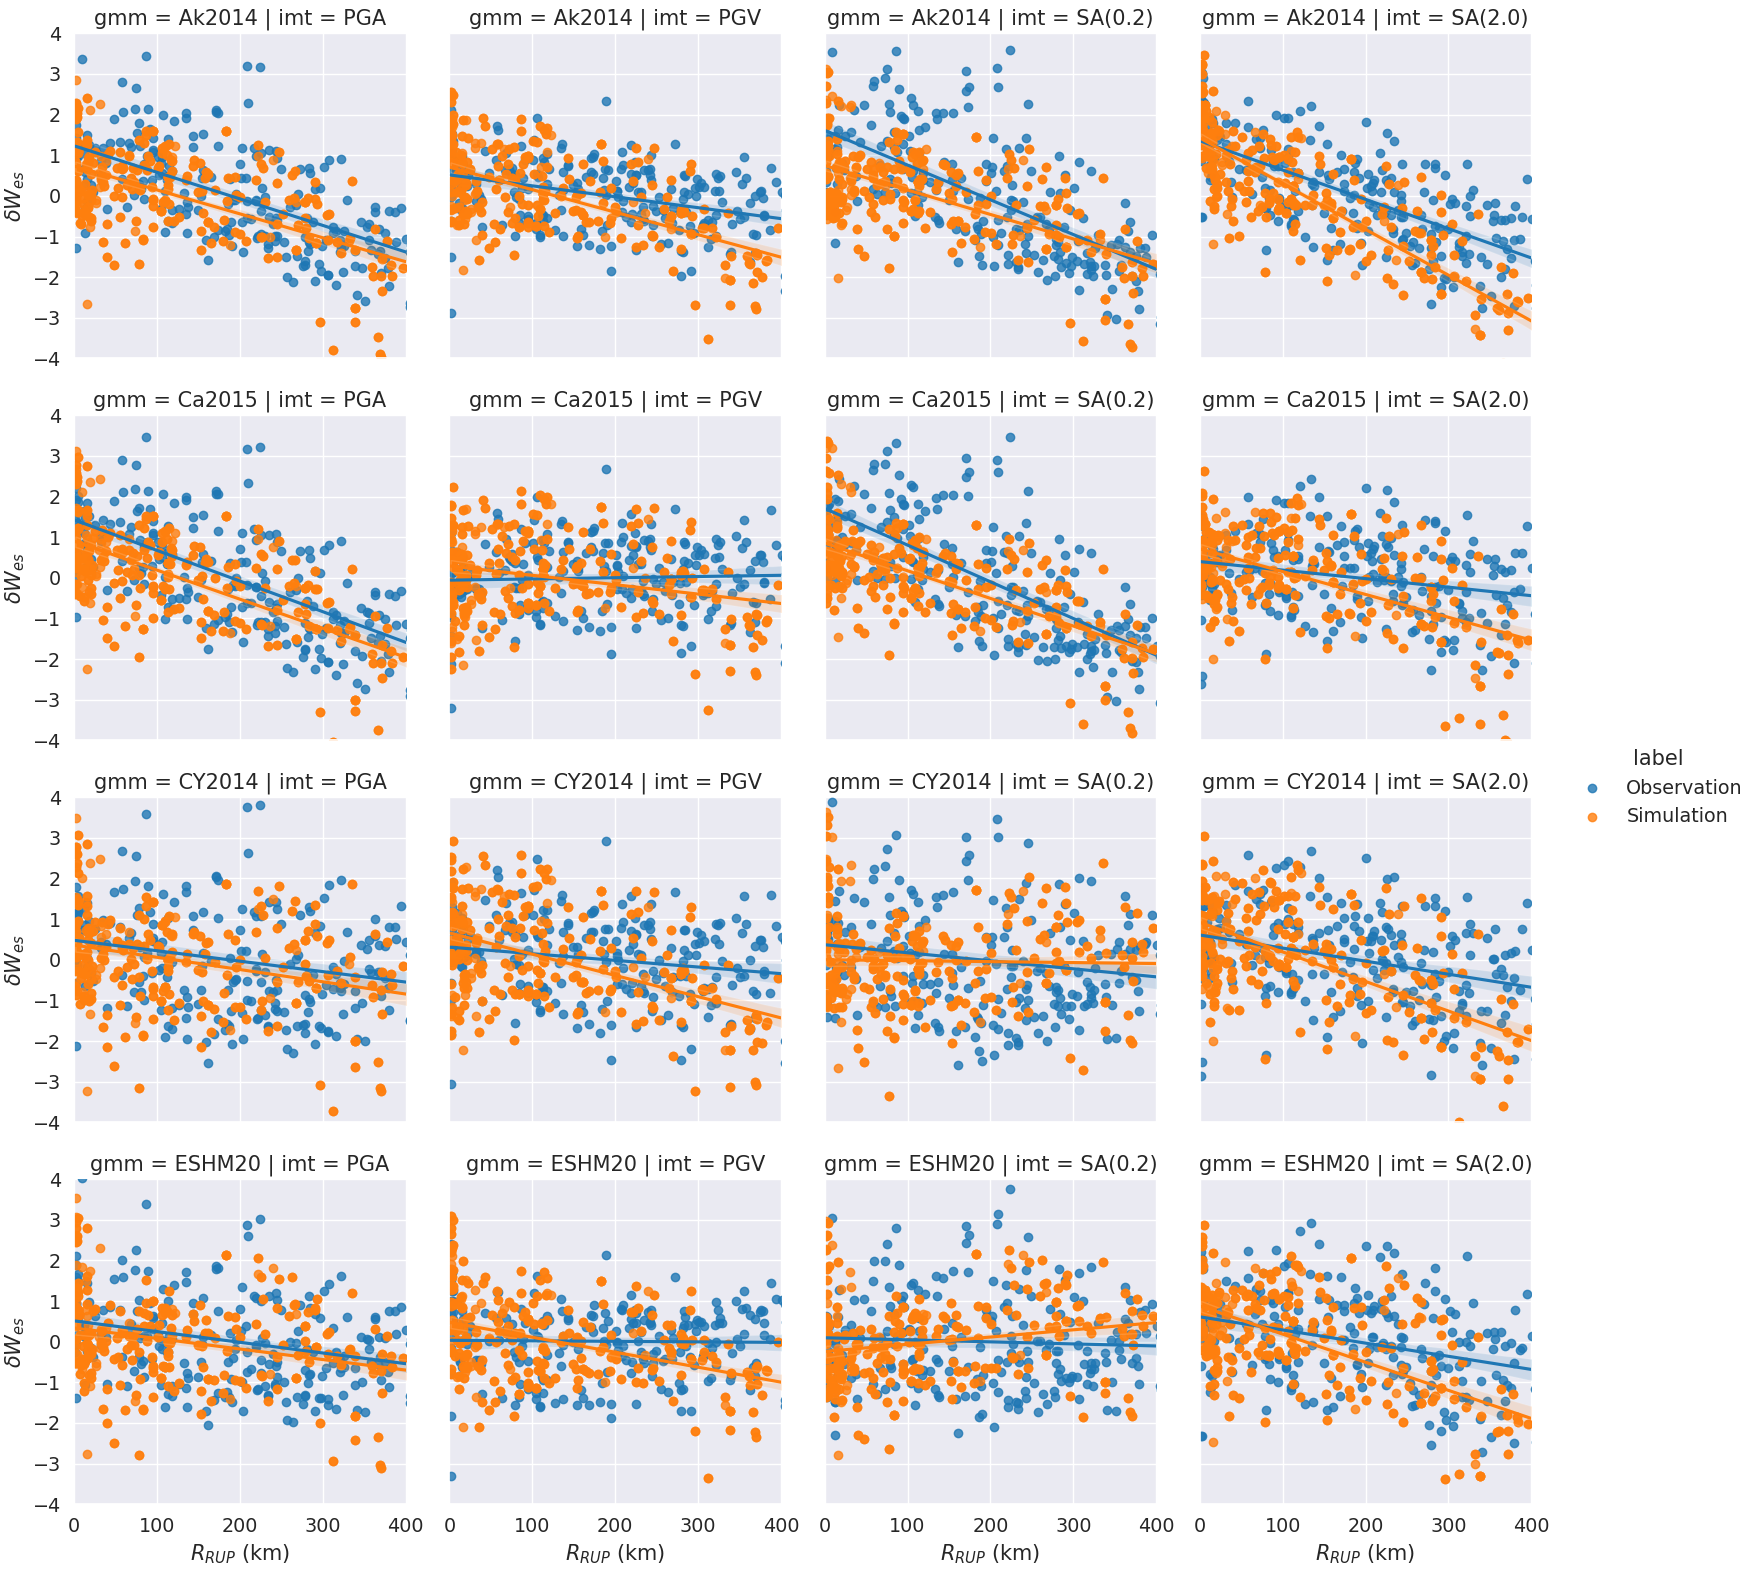

In [16]:
# Linear model plot with seaborn
with sns.axes_style("darkgrid"):
    sns.set_context("notebook", font_scale=1.25)
    # Plot with a linear model fit
    fgrid = sns.lmplot(x="rrup", y="dwes", hue="label",
                       col="imt", row="gmm", data=dwes_all, height=4)
    # Control and label axes
    fgrid.set(ylim=(-4, 4.), xscale="linear", xlim=(0, 400))
    fgrid.set_axis_labels(r"$R_{RUP}$ (km)", r"$\delta W_{es}$")
    fgrid.tight_layout()